# Data analisis de sentimientos BITCOIN

In [1]:
# === 1. IMPORTS ===

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt

# Para análisis de sentimiento
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Descargar lexicon de VADER si no está ya disponible
nltk.download('vader_lexicon')

# === 2. CARGA DEL DATASET RAW ===

# Ruta al archivo crudo (ajusta si no está aquí)
path = "/workspaces/AdriARE-dataset-NLP-BITCOIN/data/raw/12.11.25-12.12.25.noticias_raw_sentimiento.csv"

df = pd.read_csv(path)

# === 3. MOSTRAR INFORMACIÓN ===

print("Shape:", df.shape)
df.head()


Shape: (5577, 5)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,publishedAt,title,description,source,axis
0,2025-11-12T03:31:05Z,"Bitcoin Bottomed At $98,000, Analyst Says: Tim...",Bitcoin (CRYPTO: BTC) has likely established i...,Yahoo Entertainment,BTC
1,2025-11-12T21:31:08Z,Bitcoin User Accidentally Pays Over $105K To S...,A Bitcoin (CRYPTO: BTC) user paid a staggering...,Yahoo Entertainment,BTC
2,2025-11-12T19:00:00Z,Billionaire twins–backed stock surges 100% aft...,"Leap Therapeutics (Nasdaq: LPTX), a Cambridge,...",TheStreet,BTC
3,2025-11-12T19:01:08Z,"Take Profits On Bitcoin—It's 'Fall Season', Mo...","Bitcoin (CRYPTO: BTC) tapped $105,000 before r...",Yahoo Entertainment,BTC
4,2025-11-12T12:15:00Z,Demand Revival: Crypto Daybook Americas,"The day ahead in crypto: Nov. 12, 2025",CoinDesk,BTC


In [2]:
# === 4. LIMPIEZA Y NORMALIZACIÓN TEMPORAL ===

# Convertir publishedAt a datetime de forma robusta
df['datetime'] = pd.to_datetime(
    df['publishedAt'],
    utc=True,
    errors='coerce'   # convierte fechas inválidas en NaT
)

# Eliminar filas con fechas inválidas
df = df.dropna(subset=['datetime'])

# Eliminar timezone (recomendado para joins posteriores)
df['datetime'] = df['datetime'].dt.tz_convert(None)

# Comprobación rápida
print(df[['publishedAt', 'datetime']].head())
print(f"Filas finales: {len(df)}")


            publishedAt            datetime
0  2025-11-12T03:31:05Z 2025-11-12 03:31:05
1  2025-11-12T21:31:08Z 2025-11-12 21:31:08
2  2025-11-12T19:00:00Z 2025-11-12 19:00:00
3  2025-11-12T19:01:08Z 2025-11-12 19:01:08
4  2025-11-12T12:15:00Z 2025-11-12 12:15:00
Filas finales: 5576


In [3]:
# === 5. CREAR VENTANA TEMPORAL 4H ===

# Redondear hacia abajo a bloques de 4 horas
df['datetime_4h'] = df['datetime'].dt.floor('4h')

# Comprobación visual
df[['datetime', 'datetime_4h']].head(10)


,datetime,datetime_4h
0,2025-11-12 03:31:05,2025-11-12 00:00:00
1,2025-11-12 21:31:08,2025-11-12 20:00:00
2,2025-11-12 19:00:00,2025-11-12 16:00:00
3,2025-11-12 19:01:08,2025-11-12 16:00:00
4,2025-11-12 12:15:00,2025-11-12 12:00:00
5,2025-11-12 02:23:11,2025-11-12 00:00:00
6,2025-11-12 18:42:46,2025-11-12 16:00:00
7,2025-11-12 21:38:20,2025-11-12 20:00:00
8,2025-11-12 02:17:22,2025-11-12 00:00:00
9,2025-11-12 08:04:03,2025-11-12 08:00:00


In [4]:
# === 6. SEPARAR DATASETS POR AXIS ===

df_btc   = df[df['axis'] == 'BTC'].copy()
df_tech  = df[df['axis'] == 'TECH'].copy()
df_macro = df[df['axis'] == 'MACRO'].copy()

# Comprobación rápida
print("BTC:", df_btc.shape)
print("TECH:", df_tech.shape)
print("MACRO:", df_macro.shape)


BTC: (2924, 7)
TECH: (1009, 7)
MACRO: (1642, 7)


In [5]:
# === 7. PREPARAR TEXTO PARA NLP ===

# Función para combinar título + descripción de forma segura
def combinar_texto(row):
    partes = []
    if pd.notna(row['title']):
        partes.append(str(row['title']).strip())
    if pd.notna(row['description']):
        partes.append(str(row['description']).strip())
    return ' '.join(partes)

# Aplicar a cada dataset por separado (así mantenemos trazabilidad por axis)
for nombre, df_axis in [("BTC", df_btc), ("TECH", df_tech), ("MACRO", df_macro)]:
    print(f"Procesando {nombre}...")
    
    # Crear columna de texto combinado
    df_axis['text_nlp'] = df_axis.apply(combinar_texto, axis=1)
    
    # Limpieza básica: eliminar filas sin texto útil (raro, pero por seguridad)
    antes = len(df_axis)
    df_axis = df_axis[df_axis['text_nlp'].str.strip() != ''].copy()
    despues = len(df_axis)
    
    print(f"   {nombre}: {antes} → {despues} filas (perdidas: {antes - despues})")
    print(f"   Longitud media texto: {df_axis['text_nlp'].str.len().mean():.1f} caracteres")
    print(f"   Ejemplo:\n   \"{df_axis['text_nlp'].iloc[0][:200]}{'...' if len(df_axis['text_nlp'].iloc[0]) > 200 else ''}\"\n")

# Actualizar los dataframes en el entorno (importante: reasignar)
df_btc   = df_btc[df_btc['text_nlp'].str.strip() != ''].copy()
df_tech  = df_tech[df_tech['text_nlp'].str.strip() != ''].copy()
df_macro = df_macro[df_macro['text_nlp'].str.strip() != ''].copy()

print("✅ Columna 'text_nlp' creada en los 3 datasets")
print("   Campos disponibles ahora:", df_btc.columns.tolist())

Procesando BTC...
   BTC: 2924 → 2924 filas (perdidas: 0)
   Longitud media texto: 250.2 caracteres
   Ejemplo:
   "Bitcoin Bottomed At $98,000, Analyst Says: Time For The Final 'Giga Blowoff Rally' Bitcoin (CRYPTO: BTC) has likely established its bottom at $98,000, marking a key low reinforced by multiple technica..."

Procesando TECH...
   TECH: 1009 → 1009 filas (perdidas: 0)
   Longitud media texto: 273.1 caracteres
   Ejemplo:
   "Hands-on with the new Steam Machine, Valve’s square shot at SteamOS PC redemption Remember Steam Machines? Valve do, and they’re making a new one. The circa-2026 Steam Machine (it’s out early next yea..."

Procesando MACRO...
   MACRO: 1642 → 1642 filas (perdidas: 0)
   Longitud media texto: 267.4 caracteres
   Ejemplo:
   "Fed’s Miran pivots on interest-rate cut push for December Two members of the Federal Reserve’s policymaking panel dissented from its recent vote to lower interest rates. For Fed Governor Stephen Miran..."

✅ Columna 'text_nlp' creada 

In [6]:
# === 8. APLICAR ANÁLISIS DE SENTIMIENTO CON VADER ===

# Inicializar VADER (ya descargado)
sia = SentimentIntensityAnalyzer()

# Función para obtener compound score
def get_vader_score(text):
    if not text or pd.isna(text):
        return 0.0  # Neutral si vacío
    scores = sia.polarity_scores(text)
    return scores['compound']  # -1 a +1

# Aplicar a cada dataset
for nombre, df_axis in [("BTC", df_btc), ("TECH", df_tech), ("MACRO", df_macro)]:
    print(f"Calculando sentimiento para {nombre}...")
    df_axis['sentiment_score'] = df_axis['text_nlp'].apply(get_vader_score)
    
    # Sanity check: Distribución rápida
    print(f"   {nombre}: Score promedio: {df_axis['sentiment_score'].mean():.3f}")
    print(f"   Positivos (>0.05): {len(df_axis[df_axis['sentiment_score'] > 0.05])} ({len(df_axis[df_axis['sentiment_score'] > 0.05]) / len(df_axis):.1%})")
    print(f"   Negativos (<-0.05): {len(df_axis[df_axis['sentiment_score'] < -0.05])} ({len(df_axis[df_axis['sentiment_score'] < -0.05]) / len(df_axis):.1%})")
    print(f"   Neutrales: {len(df_axis[(df_axis['sentiment_score'] >= -0.05) & (df_axis['sentiment_score'] <= 0.05)])}")
    
    # Ejemplo: Uno positivo y uno negativo
    if not df_axis[df_axis['sentiment_score'] > 0.05].empty:
        ej_pos = df_axis[df_axis['sentiment_score'] > 0.05].iloc[0]
        print(f"   Ejemplo positivo (score {ej_pos['sentiment_score']:.3f}): \"{ej_pos['text_nlp'][:150]}{'...' if len(ej_pos['text_nlp']) > 150 else ''}\"")
    if not df_axis[df_axis['sentiment_score'] < -0.05].empty:
        ej_neg = df_axis[df_axis['sentiment_score'] < -0.05].iloc[0]
        print(f"   Ejemplo negativo (score {ej_neg['sentiment_score']:.3f}): \"{ej_neg['text_nlp'][:150]}{'...' if len(ej_neg['text_nlp']) > 150 else ''}\"\n")

print("✅ Sentimiento calculado en los 3 datasets.")
print("   Campos ahora:", df_btc.columns.tolist())

Calculando sentimiento para BTC...


   BTC: Score promedio: 0.241
   Positivos (>0.05): 1761 (60.2%)
   Negativos (<-0.05): 737 (25.2%)
   Neutrales: 426
   Ejemplo positivo (score 0.440): "Take Profits On Bitcoin—It's 'Fall Season', Morgan Stanley Analyst Says Bitcoin (CRYPTO: BTC) tapped $105,000 before retreating back below $104,000 on..."
   Ejemplo negativo (score -0.273): "Bitcoin Bottomed At $98,000, Analyst Says: Time For The Final 'Giga Blowoff Rally' Bitcoin (CRYPTO: BTC) has likely established its bottom at $98,000,..."

Calculando sentimiento para TECH...
   TECH: Score promedio: 0.234
   Positivos (>0.05): 620 (61.4%)
   Negativos (<-0.05): 276 (27.4%)
   Neutrales: 113
   Ejemplo positivo (score 0.859): "Three awesome mini PCs get major price cuts in Amazon’s early Black Friday sale (but you need these special codes to get 'em) Amazon has acquired a se..."
   Ejemplo negativo (score -0.542): "Hands-on with the new Steam Machine, Valve’s square shot at SteamOS PC redemption Remember Steam Machines? Valve do,

In [7]:
# === 9. CATEGORIZAR Y AGREGAR SENTIMIENTO POR VENTANA 4H ===

# 1. Crear etiqueta categórica en cada dataset
def categorize_sentiment(score):
    if score > 0.05:
        return 'positivo'
    elif score < -0.05:
        return 'negativo'
    else:
        return 'neutral'

for nombre, df_axis in [("BTC", df_btc), ("TECH", df_tech), ("MACRO", df_macro)]:
    df_axis['sentiment_label'] = df_axis['sentiment_score'].apply(categorize_sentiment)
    print(f"{nombre}: Distribución etiquetas")
    print(df_axis['sentiment_label'].value_counts(normalize=True).round(3))
    print()

# 2. Agregación individual por eje
df_btc_4h = (df_btc.groupby('datetime_4h')
            .agg(sent_btc=('sentiment_score', 'mean'),
                 count_btc=('text_nlp', 'count'))
            .reset_index())

df_tech_4h = (df_tech.groupby('datetime_4h')
              .agg(sent_tech=('sentiment_score', 'mean'),
                   count_tech=('text_nlp', 'count'))
              .reset_index())

df_macro_4h = (df_macro.groupby('datetime_4h')
               .agg(sent_macro=('sentiment_score', 'mean'),
                    count_macro=('text_nlp', 'count'))
               .reset_index())

# 3. Unir todo en un solo merge limpio
df_sent_4h = df_btc_4h.merge(df_tech_4h, on='datetime_4h', how='outer') \
                      .merge(df_macro_4h, on='datetime_4h', how='outer')

# 4. Establecer índice inmediatamente
df_sent_4h = df_sent_4h.set_index('datetime_4h')

# 5. Rellenar NaN (ejes sin noticias en esa ventana = 0 sentimiento y 0 conteo)
df_sent_4h[['sent_btc', 'sent_tech', 'sent_macro']] = df_sent_4h[['sent_btc', 'sent_tech', 'sent_macro']].fillna(0)
df_sent_4h[['count_btc', 'count_tech', 'count_macro']] = df_sent_4h[['count_btc', 'count_tech', 'count_macro']].fillna(0)

# 6. Métricas totales
df_sent_4h['sent_total'] = df_sent_4h[['sent_btc', 'sent_tech', 'sent_macro']].mean(axis=1)
df_sent_4h['count_total'] = df_sent_4h[['count_btc', 'count_tech', 'count_tech', 'count_macro']].sum(axis=1)

# Sentimiento ponderado por volumen (el que más sentido tiene para el modelo)
df_sent_4h['sent_weighted'] = (
    df_sent_4h['sent_btc'] * df_sent_4h['count_btc'] +
    df_sent_4h['sent_tech'] * df_sent_4h['count_tech'] +
    df_sent_4h['sent_macro'] * df_sent_4h['count_macro']
) / (df_sent_4h['count_total'] + 1e-8)  # evita división por cero

# Ordenar cronológicamente
df_sent_4h = df_sent_4h.sort_index()

print("✅ Agregación 4h FINAL lista")
print(f"Ventanas únicas: {len(df_sent_4h)} (aprox {len(df_sent_4h)/6:.1f} días cubiertos)")
print(f"Rango temporal: {df_sent_4h.index.min()} → {df_sent_4h.index.max()}")
df_sent_4h.tail(10)

BTC: Distribución etiquetas
sentiment_label
positivo    0.602
negativo    0.252
neutral     0.146
Name: proportion, dtype: float64

TECH: Distribución etiquetas
sentiment_label
positivo    0.614
negativo    0.274
neutral     0.112
Name: proportion, dtype: float64

MACRO: Distribución etiquetas
sentiment_label
positivo    0.552
negativo    0.346
neutral     0.102
Name: proportion, dtype: float64

✅ Agregación 4h FINAL lista
Ventanas únicas: 180 (aprox 30.0 días cubiertos)
Rango temporal: 2025-11-12 00:00:00 → 2025-12-11 20:00:00


,sent_btc,count_btc,sent_tech,count_tech,sent_macro,count_macro,sent_total,count_total,sent_weighted
datetime_4h,,,,,,,,,
2025-12-10 08:00:00,0.197960,5,0.143333,6.0,-0.217233,12.0,0.041353,29.0,-0.026103
2025-12-10 12:00:00,0.234468,28,0.142033,12.0,0.018956,16.0,0.131819,68.0,0.126071
2025-12-10 16:00:00,0.250771,24,0.363344,9.0,0.001163,27.0,0.205093,69.0,0.135072
2025-12-10 20:00:00,0.029245,20,0.037913,8.0,-0.130800,25.0,-0.021214,61.0,-0.039046
2025-12-11 00:00:00,0.057282,11,0.697100,3.0,0.088553,15.0,0.280978,32.0,0.126553
2025-12-11 04:00:00,-0.017150,12,0.451300,4.0,0.114675,16.0,0.182942,36.0,0.095394
2025-12-11 08:00:00,0.049031,13,0.720400,2.0,-0.072910,10.0,0.232174,27.0,0.049967
2025-12-11 12:00:00,0.077769,26,0.362840,10.0,-0.077265,20.0,0.121115,66.0,0.062198
2025-12-11 16:00:00,0.214619,26,0.419150,2.0,0.048973,11.0,0.227581,41.0,0.169685


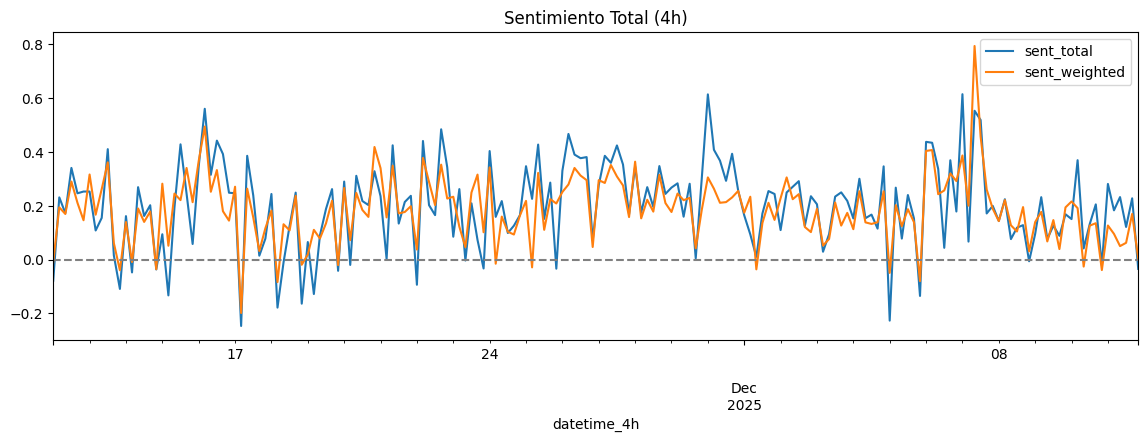

In [8]:
df_sent_4h[['sent_total', 'sent_weighted']].plot(figsize=(14,4), title="Sentimiento Total (4h)")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [15]:
# === 10. RESAMPLE A DIARIO Y GUARDAR AMBOS CSVs ===

# 1. Resample de 4h a diario (promedio de sentimiento, suma de conteos)
df_sent_daily = df_sent_4h.resample('D').agg({
    'sent_btc': 'mean',
    'sent_tech': 'mean',
    'sent_macro': 'mean',
    'sent_total': 'mean',
    'sent_weighted': 'mean',
    'count_btc': 'sum',
    'count_tech': 'sum',
    'count_macro': 'sum',
    'count_total': 'sum'
}).fillna(0)

# 2. Sanity check
print("✅ Resample diario completado")
print(f"Filas diarias: {len(df_sent_daily)} (del {df_sent_daily.index.min().date()} al {df_sent_daily.index.max().date()})")
print("\nÚltimas 10 filas (diario):")
display(df_sent_daily.tail(10))

print("\nÚltimas 10 filas (4h, recordatorio):")
display(df_sent_4h.tail(10))

# 3. Guardar ambos CSVs en processed
path_4h = PROCESSED_PATH + "sentiment_news_4h_nov_dec_2025.csv"
path_daily = PROCESSED_PATH + "sentiment_news_daily_nov_dec_2025.csv"

df_sent_4h.to_csv(path_4h)
df_sent_daily.to_csv(path_daily)

print("\n🎉 ¡CSVs guardados correctamente!")
print(f"   • 4h:     {path_4h}")
print(f"   • Diario: {path_daily}")

✅ Resample diario completado
Filas diarias: 30 (del 2025-11-12 al 2025-12-11)

Últimas 10 filas (diario):


,sent_btc,sent_tech,sent_macro,sent_total,sent_weighted,count_btc,count_tech,count_macro,count_total
datetime_4h,,,,,,,,,
2025-12-02,0.114537,0.246885,0.279207,0.213543,0.203939,98,27.0,68.0,220.0
2025-12-03,0.198307,0.135868,0.181270,0.171815,0.138135,97,42.0,63.0,244.0
2025-12-04,0.206406,0.338820,0.072319,0.205849,0.171609,97,51.0,49.0,248.0
2025-12-05,0.135967,-0.002830,0.054658,0.062598,0.087124,95,32.0,74.0,233.0
2025-12-06,0.392187,0.242714,0.265022,0.299974,0.320367,95,16.0,23.0,150.0
2025-12-07,0.477193,0.136089,0.448715,0.353999,0.381142,99,19.0,23.0,160.0
2025-12-08,0.228686,0.056205,0.056940,0.113944,0.136837,100,36.0,69.0,241.0
2025-12-09,0.173422,0.140460,0.079111,0.130997,0.127230,100,33.0,85.0,251.0
2025-12-10,0.178093,0.243054,0.017271,0.146139,0.100474,99,36.0,99.0,270.0



Últimas 10 filas (4h, recordatorio):


,sent_btc,count_btc,sent_tech,count_tech,sent_macro,count_macro,sent_total,count_total,sent_weighted
datetime_4h,,,,,,,,,
2025-12-10 08:00:00,0.197960,5,0.143333,6.0,-0.217233,12.0,0.041353,29.0,-0.026103
2025-12-10 12:00:00,0.234468,28,0.142033,12.0,0.018956,16.0,0.131819,68.0,0.126071
2025-12-10 16:00:00,0.250771,24,0.363344,9.0,0.001163,27.0,0.205093,69.0,0.135072
2025-12-10 20:00:00,0.029245,20,0.037913,8.0,-0.130800,25.0,-0.021214,61.0,-0.039046
2025-12-11 00:00:00,0.057282,11,0.697100,3.0,0.088553,15.0,0.280978,32.0,0.126553
2025-12-11 04:00:00,-0.017150,12,0.451300,4.0,0.114675,16.0,0.182942,36.0,0.095394
2025-12-11 08:00:00,0.049031,13,0.720400,2.0,-0.072910,10.0,0.232174,27.0,0.049967
2025-12-11 12:00:00,0.077769,26,0.362840,10.0,-0.077265,20.0,0.121115,66.0,0.062198
2025-12-11 16:00:00,0.214619,26,0.419150,2.0,0.048973,11.0,0.227581,41.0,0.169685



🎉 ¡CSVs guardados correctamente!
   • 4h:     /workspaces/AdriARE-dataset-NLP-BITCOIN/data/processed/sentiment_news_4h_nov_dec_2025.csv
   • Diario: /workspaces/AdriARE-dataset-NLP-BITCOIN/data/processed/sentiment_news_daily_nov_dec_2025.csv


In [11]:
# === DEFINIR PATHS (EJECUTA ESTO UNA VEZ) ===
BASE_PATH = "/workspaces/AdriARE-dataset-NLP-BITCOIN/data/"
RAW_PATH = BASE_PATH + "raw/"
PROCESSED_PATH = BASE_PATH + "processed/"

# Crear carpeta processed si no existe
import os
os.makedirs(PROCESSED_PATH, exist_ok=True)

print(f"Paths configurados:")
print(f"   Raw:       {RAW_PATH}")
print(f"   Processed: {PROCESSED_PATH}")

Paths configurados:
   Raw:       /workspaces/AdriARE-dataset-NLP-BITCOIN/data/raw/
   Processed: /workspaces/AdriARE-dataset-NLP-BITCOIN/data/processed/


Cargando FinBERT... (puede tardar 20-60 segundos la primera vez)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Aplicando FinBERT a BTC...


  0%|          | 0/2924 [00:00<?, ?it/s]

Aplicando FinBERT a TECH...


  0%|          | 0/1009 [00:00<?, ?it/s]

Aplicando FinBERT a MACRO...


  0%|          | 0/1642 [00:00<?, ?it/s]


¡Dataset 4h con FinBERT guardado en: /workspaces/AdriARE-dataset-NLP-BITCOIN/data/processed/sentiment_news_4h_FINBERT_nov_dec_2025.csv

Promedio global FinBERT (ponderado): -0.014
Promedio global VADER (ponderado): 0.185


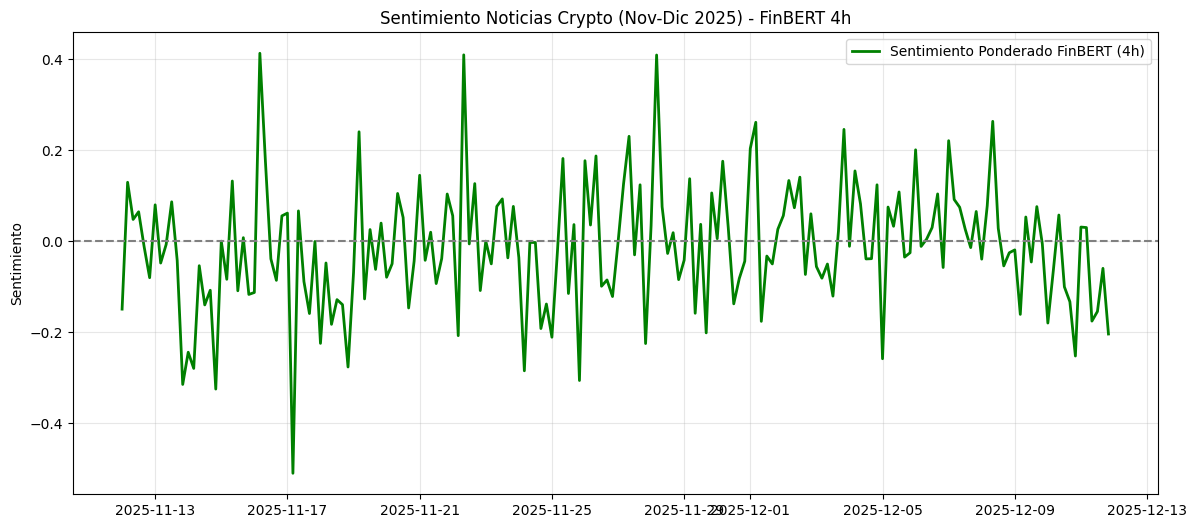

In [13]:
# === 11. RECALCULAR SENTIMIENTO CON FINBERT ===

from transformers import pipeline
import torch  
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar FinBERT
print("Cargando FinBERT... (puede tardar 20-60 segundos la primera vez)")
finbert = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=0 if torch.cuda.is_available() else -1  # GPU si disponible, sino CPU
)

# 2. Función para aplicar FinBERT
def get_finbert_score(text):
    if not text or pd.isna(text) or len(str(text).strip()) < 10:
        return 0.0
    try:
        result = finbert(text[:512])[0]  # Límite de tokens
        label = result['label']
        score = result['score']
        if label == 'positive':
            return score
        elif label == 'negative':
            return -score
        else:  # neutral
            return 0.0
    except:
        return 0.0

# 3. Aplicar a los datasets (con barra de progreso)
print("Aplicando FinBERT a BTC...")
tqdm.pandas()
df_btc['sentiment_finbert'] = df_btc['text_nlp'].progress_apply(get_finbert_score)

print("Aplicando FinBERT a TECH...")
df_tech['sentiment_finbert'] = df_tech['text_nlp'].progress_apply(get_finbert_score)

print("Aplicando FinBERT a MACRO...")
df_macro['sentiment_finbert'] = df_macro['text_nlp'].progress_apply(get_finbert_score)

# 4. Recrear agregación 4h con FinBERT
df_btc_4h_fb = df_btc.groupby('datetime_4h').agg(
    sent_btc_finbert=('sentiment_finbert', 'mean'),
    count_btc=('text_nlp', 'count')
).reset_index()

df_tech_4h_fb = df_tech.groupby('datetime_4h').agg(
    sent_tech_finbert=('sentiment_finbert', 'mean'),
    count_tech=('text_nlp', 'count')
).reset_index()

df_macro_4h_fb = df_macro.groupby('datetime_4h').agg(
    sent_macro_finbert=('sentiment_finbert', 'mean'),
    count_macro=('text_nlp', 'count')
).reset_index()

# 5. Unir y calcular totales
df_sent_4h_finbert = df_btc_4h_fb.merge(df_tech_4h_fb, on='datetime_4h', how='outer') \
                                 .merge(df_macro_4h_fb, on='datetime_4h', how='outer') \
                                 .set_index('datetime_4h')

df_sent_4h_finbert[['sent_btc_finbert', 'sent_tech_finbert', 'sent_macro_finbert']] = \
    df_sent_4h_finbert[['sent_btc_finbert', 'sent_tech_finbert', 'sent_macro_finbert']].fillna(0)
df_sent_4h_finbert[['count_btc', 'count_tech', 'count_macro']] = \
    df_sent_4h_finbert[['count_btc', 'count_tech', 'count_macro']].fillna(0)

df_sent_4h_finbert['sent_total_finbert'] = df_sent_4h_finbert[['sent_btc_finbert', 'sent_tech_finbert', 'sent_macro_finbert']].mean(axis=1)
df_sent_4h_finbert['count_total'] = df_sent_4h_finbert[['count_btc', 'count_tech', 'count_macro']].sum(axis=1)
df_sent_4h_finbert['sent_weighted_finbert'] = (
    df_sent_4h_finbert['sent_btc_finbert'] * df_sent_4h_finbert['count_btc'] +
    df_sent_4h_finbert['sent_tech_finbert'] * df_sent_4h_finbert['count_tech'] +
    df_sent_4h_finbert['sent_macro_finbert'] * df_sent_4h_finbert['count_macro']
) / (df_sent_4h_finbert['count_total'] + 1e-8)

df_sent_4h_finbert = df_sent_4h_finbert.sort_index()

# 6. Guardar
path_finbert = PROCESSED_PATH + "sentiment_news_4h_FINBERT_nov_dec_2025.csv"
df_sent_4h_finbert.to_csv(path_finbert)
print(f"\n¡Dataset 4h con FinBERT guardado en: {path_finbert}")

# 7. Comparación rápida
print("\nPromedio global FinBERT (ponderado):", df_sent_4h_finbert['sent_weighted_finbert'].mean().round(3))
if 'sent_weighted' in df_sent_4h.columns:
    print("Promedio global VADER (ponderado):", df_sent_4h['sent_weighted'].mean().round(3))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(df_sent_4h_finbert.index, df_sent_4h_finbert['sent_weighted_finbert'],
         label='Sentimiento Ponderado FinBERT (4h)', color='green', linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Sentimiento Noticias Crypto (Nov-Dic 2025) - FinBERT 4h')
plt.ylabel('Sentimiento')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

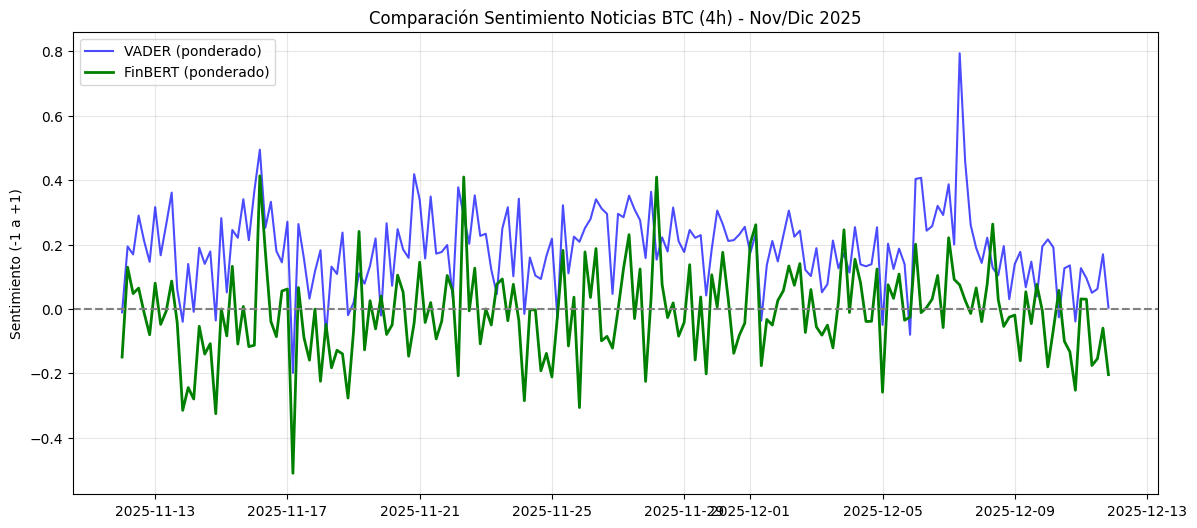

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_sent_4h.index, df_sent_4h['sent_weighted'], label='VADER (ponderado)', color='blue', alpha=0.7)
ax.plot(df_sent_4h_finbert.index, df_sent_4h_finbert['sent_weighted_finbert'], label='FinBERT (ponderado)', color='green', linewidth=2)
ax.axhline(0, color='gray', linestyle='--')
ax.set_title('Comparación Sentimiento Noticias BTC (4h) - Nov/Dic 2025')
ax.set_ylabel('Sentimiento (-1 a +1)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()